In [1]:
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

INPUT_WIDTH = 168
LABEL_WIDTH = 168
SHIFT = 168
BATCH_SIZE = 32
EPOCHS = 50

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/WrocławWeatherPredictor/data/meteo_16.9_51.103333_2025-11-30_2015-12-31.csv'
TARGET_COL = 'apparent_temperature'

if not os.path.exists(DATA_PATH):
    print(f"BŁĄD: Nie znaleziono pliku {DATA_PATH}. Sprawdź, czy dysk jest zamontowany.")
else:
    print(f"Wczytywanie danych z: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date').reset_index(drop=True)

df["hour"] = df["date"].dt.hour
df["dayofyear"] = df["date"].dt.dayofyear

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

DROP_COLS = ['date', 'hour', 'dayofyear']
cols = [c for c in df.columns if c not in DROP_COLS]

if TARGET_COL in cols:
    cols.remove(TARGET_COL)
cols = [TARGET_COL] + cols

df_clean = df[cols].copy()
FEATURES_COL = cols

print(f"Target: {TARGET_COL}")
print(f"Liczba cech wejściowych: {len(FEATURES_COL)}")

Wczytywanie danych z: /content/drive/MyDrive/Colab Notebooks/WrocławWeatherPredictor/data/meteo_16.9_51.103333_2025-11-30_2015-12-31.csv
Target: apparent_temperature
Liczba cech wejściowych: 17


In [4]:
scaler_global = StandardScaler()
data_values = scaler_global.fit_transform(df_clean.values)
data_dates = df['date']

def create_sequences_with_dates(dataset, dates, input_width, label_width, target_col_idx):
    X, y = [], []
    y_dates = []

    for i in range(len(dataset) - input_width - label_width + 1):
        X.append(dataset[i : i + input_width, :])
        y.append(dataset[i + input_width : i + input_width + label_width, target_col_idx])
        y_dates.append(dates[i + input_width])

    return np.array(X), np.array(y), pd.to_datetime(y_dates)

target_idx = 0

print("Generowanie sekwencji (to może chwilę potrwać)...")
X_all, y_all, dates_all = create_sequences_with_dates(
    data_values,
    data_dates,
    INPUT_WIDTH,
    LABEL_WIDTH,
    target_idx
)
print(f"Wygenerowano łącznie {len(X_all)} próbek.")

Generowanie sekwencji (to może chwilę potrwać)...
Wygenerowano łącznie 86593 próbek.


In [5]:
is_summer = dates_all.month.isin([4, 5, 6, 7, 8, 9])
is_winter = dates_all.month.isin([10, 11, 12, 1, 2, 3])

X_summer = X_all[is_summer]
y_summer = y_all[is_summer]

X_winter = X_all[is_winter]
y_winter = y_all[is_winter]

print(f"Próbki Letnie: {X_summer.shape}")
print(f"Próbki Zimowe: {X_winter.shape}")

def split_data(X, y):
    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.9)

    return (X[:train_end], y[:train_end]), \
           (X[train_end:val_end], y[train_end:val_end]), \
           (X[val_end:], y[val_end:])

(X_train_S, y_train_S), (X_val_S, y_val_S), (X_test_S, y_test_S) = split_data(X_summer, y_summer)
(X_train_W, y_train_W), (X_val_W, y_val_W), (X_test_W, y_test_W) = split_data(X_winter, y_winter)

Próbki Letnie: (43920, 168, 17)
Próbki Zimowe: (42673, 168, 17)


In [6]:
def build_model(name="Model"):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(INPUT_WIDTH, len(FEATURES_COL))),


        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Dense(LABEL_WIDTH)
    ], name=name)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

In [7]:
model_summer = build_model("Summer_Model")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

print("\n☀️ ROZPOCZYNAM TRENING MODELU LETNIEGO ☀️")
history_S = model_summer.fit(
    X_train_S, y_train_S,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(X_val_S, y_val_S),
    callbacks=[early_stopping], verbose=1
)

model_winter = build_model("Winter_Model")
early_stopping_W = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

print("\n❄️ ROZPOCZYNAM TRENING MODELU ZIMOWEGO ❄️")
history_W = model_winter.fit(
    X_train_W, y_train_W,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(X_val_W, y_val_W),
    callbacks=[early_stopping_W], verbose=1
)


☀️ ROZPOCZYNAM TRENING MODELU LETNIEGO ☀️
Epoch 1/50
961/961 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.1496 - mean_absolute_error: 0.4302 - val_loss: 0.0919 - val_mean_absolute_error: 0.3386
Epoch 2/50
961/961 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.0677 - mean_absolute_error: 0.2914 - val_loss: 0.1048 - val_mean_absolute_error: 0.3582
Epoch 3/50
961/961 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.0528 - mean_absolute_error: 0.2559 - val_loss: 0.1086 - val_mean_absolute_error: 0.3652
Epoch 4/50
961/961 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.0404 - mean_absolute_error: 0.2230 - val_loss: 0.1146 - val_mean_absolute_error: 0.3783
Epoch 5/50
961/961 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.0324 - mean_absolute_error: 0.1997 - val_loss: 0.1097 - val_mean_absolute_error: 0.3691
Epoch 6/50
961/961 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.0279 - mean_absolute_error: 0.1850 - val_loss: 0.1088 - val_mean_absolute_error: 0.3674

❄️ ROZPOCZYNAM TRENING MODELU ZIMOWEGO ❄️
Ep

In [8]:
tf.keras.utils.plot_model(model_summer, to_file='rysunek_summer.png', show_shapes=True)
model_summer.summary()
tf.keras.utils.plot_model(model_winter, to_file='rysunek_winter.png', show_shapes=True)
model_winter.summary()

Model: "Summer_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 168, 128)       │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 168)            │        10,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,938 (1.17 MB)

 Trainable params: 102,312 (399.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 204,626 (799.32 KB)

Model: "Winter_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 168, 128)       │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 168)            │        10,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,938 (1.17 MB)

 Trainable params: 102,312 (399.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 204,626 (799.32 KB)

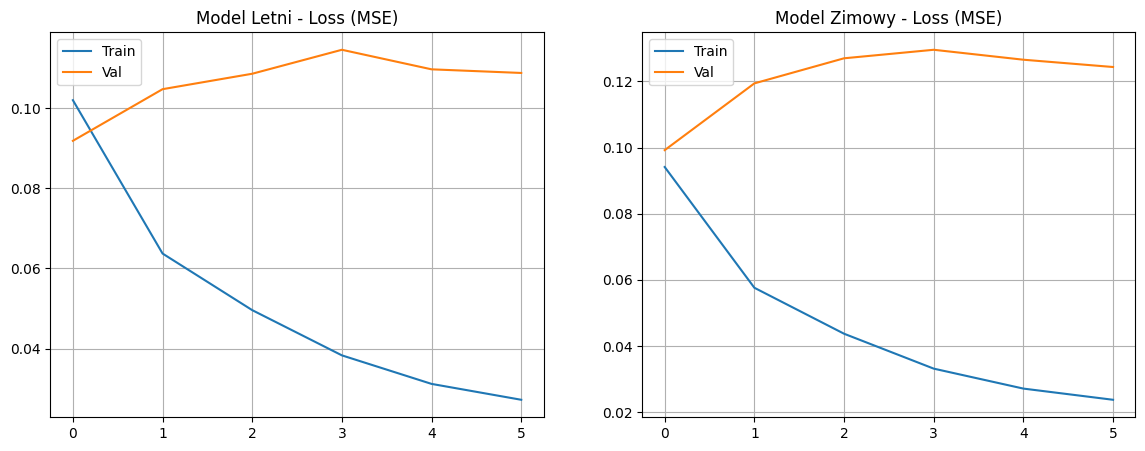


=== WYNIKI TESTU KRZYŻOWEGO ===
[Model Letni] na danych [LATO]:
   -> Scaled MAE: 0.3749
   -> Real MAE (szacunkowy): 3.75°C
[Model Zimowy] na danych [ZIMA]:
   -> Scaled MAE: 0.2976
   -> Real MAE (szacunkowy): 2.98°C
---
[Model Letni] na danych [ZIMA]:
   -> Scaled MAE: 0.4814
   -> Real MAE (szacunkowy): 4.82°C
[Model Zimowy] na danych [LATO]:
   -> Scaled MAE: 0.6822
   -> Real MAE (szacunkowy): 6.83°C


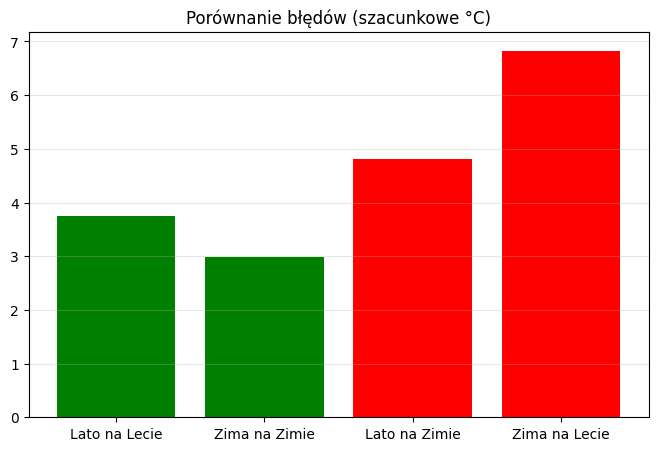

Rysowanie wykresu błędu godzinowego: LATO...


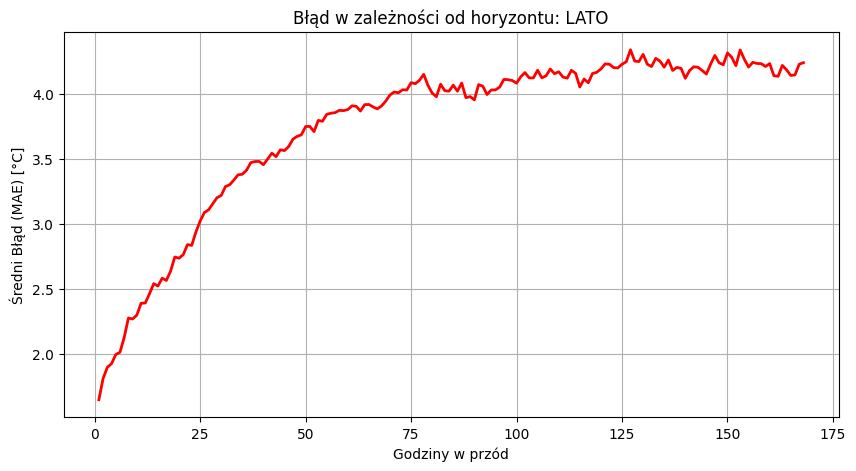

Rysowanie wykresu błędu godzinowego: ZIMA...


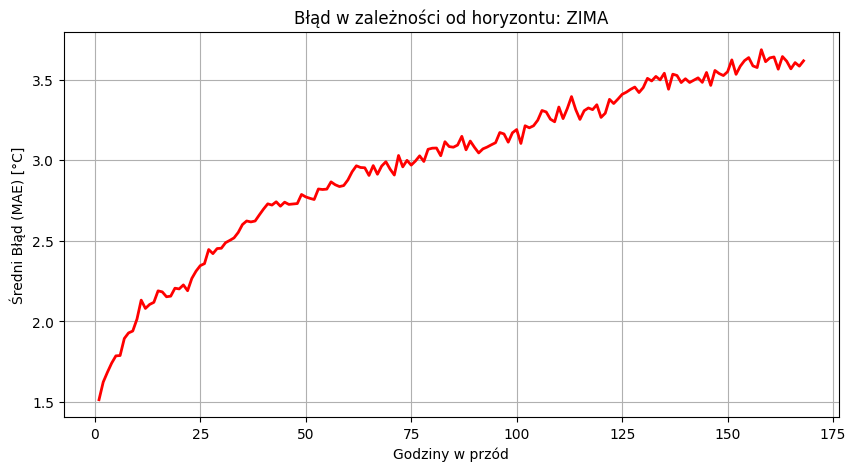


--- PRZYKŁADOWA PROGNOZA ---


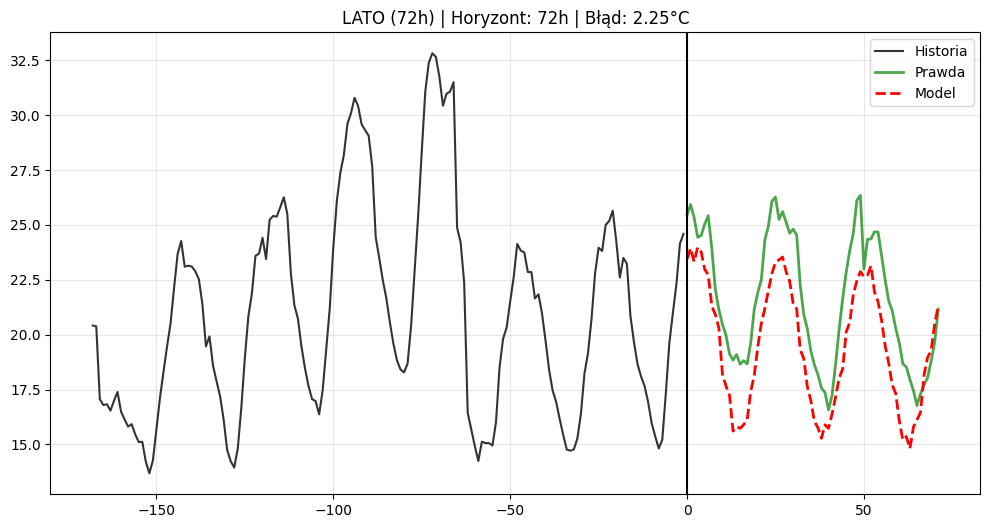

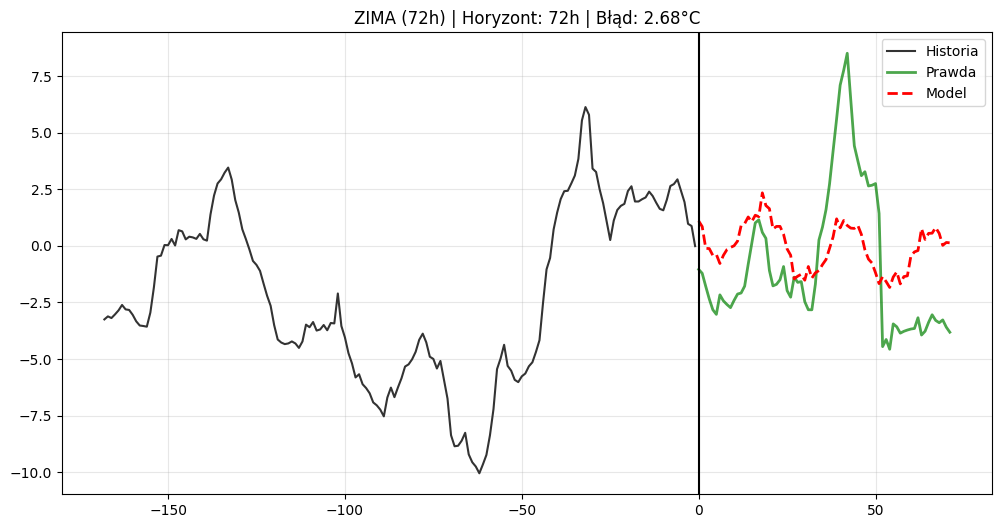

In [19]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_S.history['loss'], label='Train')
plt.plot(history_S.history['val_loss'], label='Val')
plt.title("Model Letni - Loss (MSE)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_W.history['loss'], label='Train')
plt.plot(history_W.history['val_loss'], label='Val')
plt.title("Model Zimowy - Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

def evaluate_cross_performance(model, X_test, y_test, scaler, model_name, data_name):
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    std_dev = scaler.scale_[target_idx]
    real_mae = mae * std_dev

    print(f"[{model_name}] na danych [{data_name}]:")
    print(f"   -> Scaled MAE: {mae:.4f}")
    print(f"   -> Real MAE (szacunkowy): {real_mae:.2f}°C")
    return real_mae

print("\n=== WYNIKI TESTU KRZYŻOWEGO ===")
mae_SS = evaluate_cross_performance(model_summer, X_test_S, y_test_S, scaler_global, "Model Letni", "LATO")
mae_WW = evaluate_cross_performance(model_winter, X_test_W, y_test_W, scaler_global, "Model Zimowy", "ZIMA")
print("---")
mae_SW = evaluate_cross_performance(model_summer, X_test_W, y_test_W, scaler_global, "Model Letni", "ZIMA")
mae_WS = evaluate_cross_performance(model_winter, X_test_S, y_test_S, scaler_global, "Model Zimowy", "LATO")

plt.figure(figsize=(8, 5))
plt.bar(['Lato na Lecie', 'Zima na Zimie', 'Lato na Zimie', 'Zima na Lecie'],
        [mae_SS, mae_WW, mae_SW, mae_WS],
        color=['green', 'green', 'red', 'red'])
plt.title("Porównanie błędów (szacunkowe °C)")
plt.grid(axis='y', alpha=0.3)
plt.show()

def plot_error_by_hour(model, X_test, y_test, scaler, title_suffix=""):
    print(f"Rysowanie wykresu błędu godzinowego: {title_suffix}...")
    predictions = model.predict(X_test, verbose=0)
    n_features = scaler.n_features_in_

    dummy_pred = np.zeros((predictions.shape[0], predictions.shape[1], n_features))
    dummy_pred[:, :, target_idx] = predictions

    dummy_true = np.zeros((y_test.shape[0], y_test.shape[1], n_features))
    dummy_true[:, :, target_idx] = y_test

    N, T, F = dummy_pred.shape

    pred_unscaled = scaler.inverse_transform(dummy_pred.reshape(N*T, F))[:, target_idx].reshape(N, T)
    true_unscaled = scaler.inverse_transform(dummy_true.reshape(N*T, F))[:, target_idx].reshape(N, T)

    mae_per_hour = np.mean(np.abs(pred_unscaled - true_unscaled), axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 169), mae_per_hour, color='red', linewidth=2)
    plt.title(f'Błąd w zależności od horyzontu: {title_suffix}')
    plt.xlabel('Godziny w przód')
    plt.ylabel('Średni Błąd (MAE) [°C]')
    plt.grid(True)
    plt.show()

plot_error_by_hour(model_summer, X_test_S, y_test_S, scaler_global, "LATO")
plot_error_by_hour(model_winter, X_test_W, y_test_W, scaler_global, "ZIMA")

def interactive_forecast(model, X_test, y_test, scaler, hours_to_predict=168, title="Prognoza"):
    if hours_to_predict > 168: hours_to_predict = 168

    idx = np.random.randint(0, len(X_test))
    input_seq = X_test[idx]
    true_future = y_test[idx]

    full_prediction = model.predict(input_seq[np.newaxis, ...], verbose=0)[0]
    n_features = scaler.n_features_in_

    dummy_pred = np.zeros((len(full_prediction), n_features))
    dummy_pred[:, target_idx] = full_prediction
    pred_unscaled = scaler.inverse_transform(dummy_pred)[:, target_idx]

    dummy_true = np.zeros((len(true_future), n_features))
    dummy_true[:, target_idx] = true_future
    true_unscaled = scaler.inverse_transform(dummy_true)[:, target_idx]

    history_unscaled = scaler.inverse_transform(input_seq)[:, target_idx]

    pred_cut = pred_unscaled[:hours_to_predict]
    true_cut = true_unscaled[:hours_to_predict]
    local_mae = np.mean(np.abs(pred_cut - true_cut))

    plt.figure(figsize=(12, 6))
    hist_range = np.arange(-len(history_unscaled), 0)
    plt.plot(hist_range, history_unscaled, color='#333333', label='Historia')

    future_range = np.arange(0, hours_to_predict)
    plt.plot(future_range, true_cut, color='green', label='Prawda', linewidth=2, alpha=0.7)
    plt.plot(future_range, pred_cut, color='red', linestyle='--', label='Model', linewidth=2)

    plt.title(f'{title} | Horyzont: {hours_to_predict}h | Błąd: {local_mae:.2f}°C')
    plt.axvline(0, color='black')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

print("\n--- PRZYKŁADOWA PROGNOZA ---")
interactive_forecast(model_summer, X_test_S, y_test_S, scaler_global, 72, "LATO (72h)")
interactive_forecast(model_winter, X_test_W, y_test_W, scaler_global, 72, "ZIMA (72h)")

In [10]:
# Utworzenie folderu na obrazki do raportu
if not os.path.exists('img'):
    os.makedirs('img')

# --- 1. Funkcja do zapisu wykresu błędu w czasie (Error Horizon) ---
def save_error_plot(model, X_test, y_test, scaler, name, filename):
    predictions = model.predict(X_test, verbose=0)
    n_features = scaler.n_features_in_

    # Denormalizacja
    dummy_pred = np.zeros((predictions.shape[0], predictions.shape[1], n_features))
    dummy_pred[:, :, target_idx] = predictions

    dummy_true = np.zeros((y_test.shape[0], y_test.shape[1], n_features))
    dummy_true[:, :, target_idx] = y_test

    N, T, F = dummy_pred.shape
    pred_unscaled = scaler.inverse_transform(dummy_pred.reshape(N*T, F))[:, target_idx].reshape(N, T)
    true_unscaled = scaler.inverse_transform(dummy_true.reshape(N*T, F))[:, target_idx].reshape(N, T)

    mae_per_hour = np.mean(np.abs(pred_unscaled - true_unscaled), axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 169), mae_per_hour, color='red', linewidth=2)
    plt.title(f'Średni błąd bezwzględny (MAE) w zależności od horyzontu - {name}')
    plt.xlabel('Godziny w przód (Horyzont predykcji)')
    plt.ylabel('MAE [°C]')
    plt.grid(True)

    # Zaznaczenie 24h i 168h
    plt.axvline(x=24, color='gray', linestyle='--')
    plt.text(26, mae_per_hour[23], f'24h: {mae_per_hour[23]:.2f}°C')
    plt.axvline(x=168, color='gray', linestyle='--')
    plt.text(140, mae_per_hour[167], f'168h: {mae_per_hour[167]:.2f}°C')

    plt.savefig(f'img/{filename}.png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Zapisano wykres błędu: img/{filename}.png")

    return np.mean(mae_per_hour) # Zwraca średni błąd dla całego tygodnia

# --- 2. Funkcja do zapisu przykładowej predykcji ---
def save_prediction_example(model, X_test, y_test, scaler, name, filename):
    # Szukamy "ciekawej" próbki (nie płaskiej), żeby ładnie wyglądała w raporcie
    # Losujemy aż trafimy na taką z odchyleniem > 2 stopnie
    for _ in range(100):
        idx = np.random.randint(0, len(X_test))
        input_seq = X_test[idx]
        true_future = y_test[idx]

        full_prediction = model.predict(input_seq[np.newaxis, ...], verbose=0)[0]
        n_features = scaler.n_features_in_

        # Denormalizacja
        dummy_pred = np.zeros((len(full_prediction), n_features))
        dummy_pred[:, target_idx] = full_prediction
        pred_unscaled = scaler.inverse_transform(dummy_pred)[:, target_idx]

        dummy_true = np.zeros((len(true_future), n_features))
        dummy_true[:, target_idx] = true_future
        true_unscaled = scaler.inverse_transform(dummy_true)[:, target_idx]

        if np.std(true_unscaled) > 2.0: # Warunek "ciekawej" próbki
            break

    history_unscaled = scaler.inverse_transform(input_seq)[:, target_idx]

    plt.figure(figsize=(10, 5))
    # Rysujemy historię (ostatnie 3 dni dla czytelności, zamiast 7)
    hist_range = np.arange(-72, 0)
    plt.plot(hist_range, history_unscaled[-72:], color='black', label='Historia (ostatnie 3 dni)')

    future_range = np.arange(0, 168)
    plt.plot(future_range, true_unscaled, color='green', label='Wartość rzeczywista', linewidth=2, alpha=0.7)
    plt.plot(future_range, pred_unscaled, color='red', linestyle='--', label='Predykcja modelu', linewidth=2)

    plt.title(f'Przykładowa prognoza 7-dniowa: {name}')
    plt.xlabel('Godziny od momentu prognozy')
    plt.ylabel('Temperatura odczuwalna [°C]')
    plt.axvline(0, color='black', linewidth=1)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig(f'img/{filename}.png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Zapisano przykład predykcji: img/{filename}.png")

# --- GENEROWANIE RAPORTU ---
print("--- Generowanie materiałów do LaTeX ---")

# 1. Wykresy błędów (Error decay)
mae_summer_total = save_error_plot(model_summer, X_test_S, y_test_S, scaler_global, "Model Letni", "summer_error_decay")
mae_winter_total = save_error_plot(model_winter, X_test_W, y_test_W, scaler_global, "Model Zimowy", "winter_error_decay")

# 2. Przykłady predykcji
save_prediction_example(model_summer, X_test_S, y_test_S, scaler_global, "Model Letni", "summer_prediction_ex")
save_prediction_example(model_winter, X_test_W, y_test_W, scaler_global, "Model Zimowy", "winter_prediction_ex")

print("\n--- STATYSTYKI DO WPISANIA W TEKST ---")
print(f"Średni błąd (MAE) LATO: {mae_summer_total:.2f} °C")
print(f"Średni błąd (MAE) ZIMA: {mae_winter_total:.2f} °C")

--- Generowanie materiałów do LaTeX ---
Zapisano wykres błędu: img/summer_error_decay.png
Zapisano wykres błędu: img/winter_error_decay.png
Zapisano przykład predykcji: img/summer_prediction_ex.png
Zapisano przykład predykcji: img/winter_prediction_ex.png

--- STATYSTYKI DO WPISANIA W TEKST ---
Średni błąd (MAE) LATO: 3.75 °C
Średni błąd (MAE) ZIMA: 2.98 °C
